# Finetuning of BERT

In [3]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction

import torch
import numpy as np
import pandas as pd
import random

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Features, Value, DatasetDict
from tqdm import tqdm

seed = 6
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
df = load_dataset('csv', data_files='dataset/recipes_80k_cleaned.csv')

In [5]:
# see datatype of df
print(type(df))

<class 'datasets.dataset_dict.DatasetDict'>


In [6]:
df.keys()

dict_keys(['train'])

In [7]:
df['train'].features

{'Unnamed: 0': Value(dtype='int64', id=None),
 'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Vegetarian&Desserts': Value(dtype='int64', id=None),
 'Vegetarian': Value(dtype='int64', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None)}

In [8]:
# drop the first column
df['train'] = df['train'].remove_columns('Unnamed: 0')

In [9]:
# first 5 instances of dataset
df['train'][:5]

{'cooking_method': ["['Set the racks in the middle and upper thirds of the oven and preheat the oven to 425 F', 'In a large skillet over medium heat, heat the olive oil until shimmering. Add the onion, garlic and red pepper flakes and cook until golden, stirring occasionally, about 5 minutes.', 'Add the fennel and cook until the vegetables are soft and translucent, an additional 3 to 5 minutes.', 'Reduce the heat to medium and add the tomatoes with their juices. Using the back of a wooden spoon, smash the tomatoes and cook for 5 minutes.', 'Add the basil, wine, olives, 1 teaspoon salt, and 1/8 teaspoon black pepper.', 'Reduce to low and simmer for 15 minutes, or until the sauce is slightly thickened, while you prepare the fish.', 'Pat the fillets dry, lightly spray them with cooking spray, and season with salt and pepper.', 'In a heavy ovenproof skillet over high heat, heat the olive oil until shimmering. Add the fillets, rounded-side down, and cook for 2 minutes.', 'Carefully flip the

## Data Casting
As we can see a few cells above, the first 4 features are already in the wanted data type: `string`. Let's cast the others into `bool` (... and make other adjustments). 

In [10]:
# REMOVE columns Vegetarian, Others
df = df.remove_columns(['Vegetarian'])

df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Vegetarian&Desserts': Value(dtype='int64', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None)}

In [11]:
# RENAME columns Vegetarian&Dessert to Veg, Others&Dessert to NonVeg

# Define a function to rename columns
def rename_columns(example):
    # Rename 'Vegetarian&Dessert' to 'Veg'
    if 'Vegetarian&Desserts' in example:
        example['Veg'] = example.pop('Vegetarian&Desserts')
    # Rename 'Others&Dessert' to 'NonVeg'
    if 'Others&D' in example:
        example['NonVeg'] = example.pop('Others&D')
    return example

# Apply the rename_columns function to each example in the dataset
for split in df.keys():
    df[split] = df[split].map(rename_columns)

df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='int64', id=None),
 'Gluten Free': Value(dtype='int64', id=None),
 'Low Carb': Value(dtype='int64', id=None),
 'Low Fat': Value(dtype='int64', id=None),
 'Low Sodium': Value(dtype='int64', id=None),
 'Veg': Value(dtype='int64', id=None)}

In [12]:
# CAST variables to boolean
df['train'] = df['train'].cast(Features({
    'cooking_method' : Value('string'),
    'ingredients' : Value('string'),
    'recipe_name' : Value('string'),
    'tags' : Value('string'),
    'Dairy Free': Value('bool'),
    'Gluten Free': Value('bool'),
    'Low Carb': Value('bool'),
    'Low Fat': Value('bool'),
    'Low Sodium': Value('bool'),
    'Veg': Value('bool')
}))

df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': Value(dtype='bool', id=None)}

## Split

In [13]:
# Percentage of Veg recipes
sum(df['train']['Veg'])/len(df['train'])*100

33.50841116864455

In [14]:
# count how many recipes have 'cooking_method' of more than 512 tokens

"""count = 0
for i in tqdm(range(len(df['train']))):
    if len(df['train']['cooking_method'][i].split()) > 512:
        count += 1

print(count)"""

"count = 0\nfor i in tqdm(range(len(df['train']))):\n    if len(df['train']['cooking_method'][i].split()) > 512:\n        count += 1\n\nprint(count)"

In [15]:
# drop these instances
df['train'] = df['train'].filter(lambda x: len(x['cooking_method'].split()) <= 512)

In [16]:

len(df['train'])

79375

In [17]:
sum(df['train']['Veg'])/len(df['train'])*100

33.1867716535433

In [18]:
# column we want to stratify with respect to
stratify_column_name = "Veg"

# create class label column and stratify
df['train'] = df['train'].class_encode_column(stratify_column_name)

In [19]:
df['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': ClassLabel(names=['False', 'True'], id=None)}

In [20]:
# see percentage of Veg == True 
sum(df['train']['Veg'])/len(df['train'])*100

33.1867716535433

In [21]:
# split the dataset into train, validation and test stratifying with respect to Veg
df = df['train'].train_test_split(test_size=0.3, seed = seed, stratify_by_column = 'Veg')
train_validation = df['train'].train_test_split(test_size=0.2, seed = seed, stratify_by_column='Veg')

dataset = DatasetDict()
dataset['test'] = df['test']
dataset['train'] = train_validation['train']
dataset['validation'] = train_validation['test']
dataset.shape

{'test': (23813, 10), 'train': (44449, 10), 'validation': (11113, 10)}

In [22]:
# CAST 'Veg' back to boolean for split in dataset.keys()
dataset = dataset.cast(Features({
    'cooking_method' : Value('string'),
    'ingredients' : Value('string'),
    'recipe_name' : Value('string'),
    'tags' : Value('string'),
    'Dairy Free': Value('bool'),
    'Gluten Free': Value('bool'),
    'Low Carb': Value('bool'),
    'Low Fat': Value('bool'),
    'Low Sodium': Value('bool'),
    'Veg': Value('bool')
}))

In [23]:
dataset['train'].features

{'cooking_method': Value(dtype='string', id=None),
 'ingredients': Value(dtype='string', id=None),
 'recipe_name': Value(dtype='string', id=None),
 'tags': Value(dtype='string', id=None),
 'Dairy Free': Value(dtype='bool', id=None),
 'Gluten Free': Value(dtype='bool', id=None),
 'Low Carb': Value(dtype='bool', id=None),
 'Low Fat': Value(dtype='bool', id=None),
 'Low Sodium': Value(dtype='bool', id=None),
 'Veg': Value(dtype='bool', id=None)}

In [24]:
# print the distribution of each label: Veg, Dairy Free, Gluten Free, Low Carb, Low Fat, Low Sodium in the train, test and val set

def class_distribution(dataset, column):
    num_1 = sum(dataset[column])
    num_0 = len(dataset) - num_1
    perc_1 = num_1/len(dataset)*100
    perc_0 = num_0/len(dataset)*100
    if column == 'Veg':
        return f"Vegetarian 1: \t {round(perc_1, 1)}% \t Vegetarian 0:\t {round(perc_0, 1)}%"
    return f"{column} 1: \t {round(perc_1, 1)}% \t {column} 0:\t {round(perc_0, 1)}%"


for split in dataset.keys():
    print(split)
    for column in dataset[split].features:
        if dataset[split].features[column].dtype == 'bool' or dataset[split].features[column].dtype == 'ClassLabel':
            print(class_distribution(dataset[split], column))
    print("\n")

test
Dairy Free 1: 	 0.5% 	 Dairy Free 0:	 99.5%
Gluten Free 1: 	 44.2% 	 Gluten Free 0:	 55.8%
Low Carb 1: 	 4.8% 	 Low Carb 0:	 95.2%
Low Fat 1: 	 11.1% 	 Low Fat 0:	 88.9%
Low Sodium 1: 	 18.5% 	 Low Sodium 0:	 81.5%
Vegetarian 1: 	 33.2% 	 Vegetarian 0:	 66.8%


train
Dairy Free 1: 	 0.5% 	 Dairy Free 0:	 99.5%
Gluten Free 1: 	 44.1% 	 Gluten Free 0:	 55.9%
Low Carb 1: 	 5.0% 	 Low Carb 0:	 95.0%
Low Fat 1: 	 11.5% 	 Low Fat 0:	 88.5%
Low Sodium 1: 	 19.1% 	 Low Sodium 0:	 80.9%
Vegetarian 1: 	 33.2% 	 Vegetarian 0:	 66.8%


validation
Dairy Free 1: 	 0.5% 	 Dairy Free 0:	 99.5%
Gluten Free 1: 	 43.9% 	 Gluten Free 0:	 56.1%
Low Carb 1: 	 5.0% 	 Low Carb 0:	 95.0%
Low Fat 1: 	 11.5% 	 Low Fat 0:	 88.5%
Low Sodium 1: 	 18.6% 	 Low Sodium 0:	 81.4%
Vegetarian 1: 	 33.2% 	 Vegetarian 0:	 66.8%




!!! Notice that from now on it is immediate to switch to the multi-labels case !!!

In [25]:
dataset['train'].features.keys()

dict_keys(['cooking_method', 'ingredients', 'recipe_name', 'tags', 'Dairy Free', 'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium', 'Veg'])

In [26]:
labels = [label for label in dataset['train'].features.keys() if label not in ['cooking_method','ingredients','recipe_name','tags','NonVeg']]
labels

['Dairy Free', 'Gluten Free', 'Low Carb', 'Low Fat', 'Low Sodium', 'Veg']

In [27]:
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

id2label, label2id

({0: 'Dairy Free',
  1: 'Gluten Free',
  2: 'Low Carb',
  3: 'Low Fat',
  4: 'Low Sodium',
  5: 'Veg'},
 {'Dairy Free': 0,
  'Gluten Free': 1,
  'Low Carb': 2,
  'Low Fat': 3,
  'Low Sodium': 4,
  'Veg': 5})

In [28]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

c:\Users\chucki\Desktop\projects\HLT-Project\.venv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["cooking_method"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [30]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/23813 [00:00<?, ? examples/s]

Map:   0%|          | 0/44449 [00:00<?, ? examples/s]

Map:   0%|          | 0/11113 [00:00<?, ? examples/s]

In [31]:
encoded_dataset['train'].features

{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

In [32]:
i = encoded_dataset['train'][0]['input_ids']
len(i)

512

In [33]:
tokenizer.decode(i)

"[CLS] ['Preheat a grill or grill pan for cooking at medium - high heat. ','Insert a 6 - inch caramel apple skewer a couple of inches into the base of each ear of corn. Grill the corn, turning occasionally, until tender and charred in spots, about 10 minutes. ','Meanwhile, mix together the mayonnaise, smoked paprika, lemon zest and juice and 1 / 4 teaspoon salt. ','Slather the seasoned mayonnaise all over the corn and sprinkle with the Parmesan. Dust lightly with chipotle powder and serve.'] [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [34]:
encoded_dataset['train'][0]['labels']

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

In [35]:
# !!! useful for multi-labels case: see which labels it has
[id2label[idx] for idx, label in enumerate(encoded_dataset['train'][0]['labels']) if label == 1.0]

['Gluten Free']

In [36]:
encoded_dataset.set_format("torch")

In [32]:
type(encoded_dataset)

datasets.dataset_dict.DatasetDict

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", 
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id
                                                           )

# Train the model!

In [ ]:
args = TrainingArguments(
    f"google-bert/bert-base-cased",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    save_steps=500,
    eval_steps=500,
    save_total_limit=2,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    #push_to_hub=True,
)

In [63]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

# evaluate

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model("./models/bert-finetuned-group15")

In [ ]:
text = "meat meat meat meat"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)
logits = outputs.logits

In [ ]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
"""togliere commenti per stampare le labels corrispondenti"""
# predictions[np.where(probs >= 0.7)] = 1
# turn predicted id's into actual label names
#predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
probs

---

# Testing the finetuned model

In [38]:
model = AutoModelForSequenceClassification.from_pretrained("./models/bert-finetuned2-group15")
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [39]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def multi_label_metrics_test(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    
    return metrics, y_true, y_pred

def compute_metrics_test(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result, y_true, y_pred = multi_label_metrics_test(
        predictions=preds, 
        labels=p.label_ids)
    
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    fig, axs = plt.subplots(2, 3, figsize=(16, 9))

    for i, cm in enumerate(mcm):
        row = i // 3
        col = i % 3
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[row, col])
        axs[row, col].set_xlabel('Predicted labels')
        axs[row, col].set_ylabel('True labels')
        axs[row, col].set_title(f'Label: {id2label[i]}')

    plt.subplots_adjust(hspace = 0.3)
    plt.show()

    return result

In [40]:
dataset['test']
print("Keys in dataset:", dataset.keys())

# Check the length of the test dataset
print("Length of test dataset:", len(dataset['test']))

print(len(dataset['test']))

Keys in dataset: dict_keys(['test', 'train', 'validation'])
Length of test dataset: 23813
23813


In [41]:
#take first 10 element of encoded_dataset

sub_encoded_dataset = encoded_dataset['test'].select(list(range(10)))

  0%|          | 0/2977 [00:00<?, ?it/s]

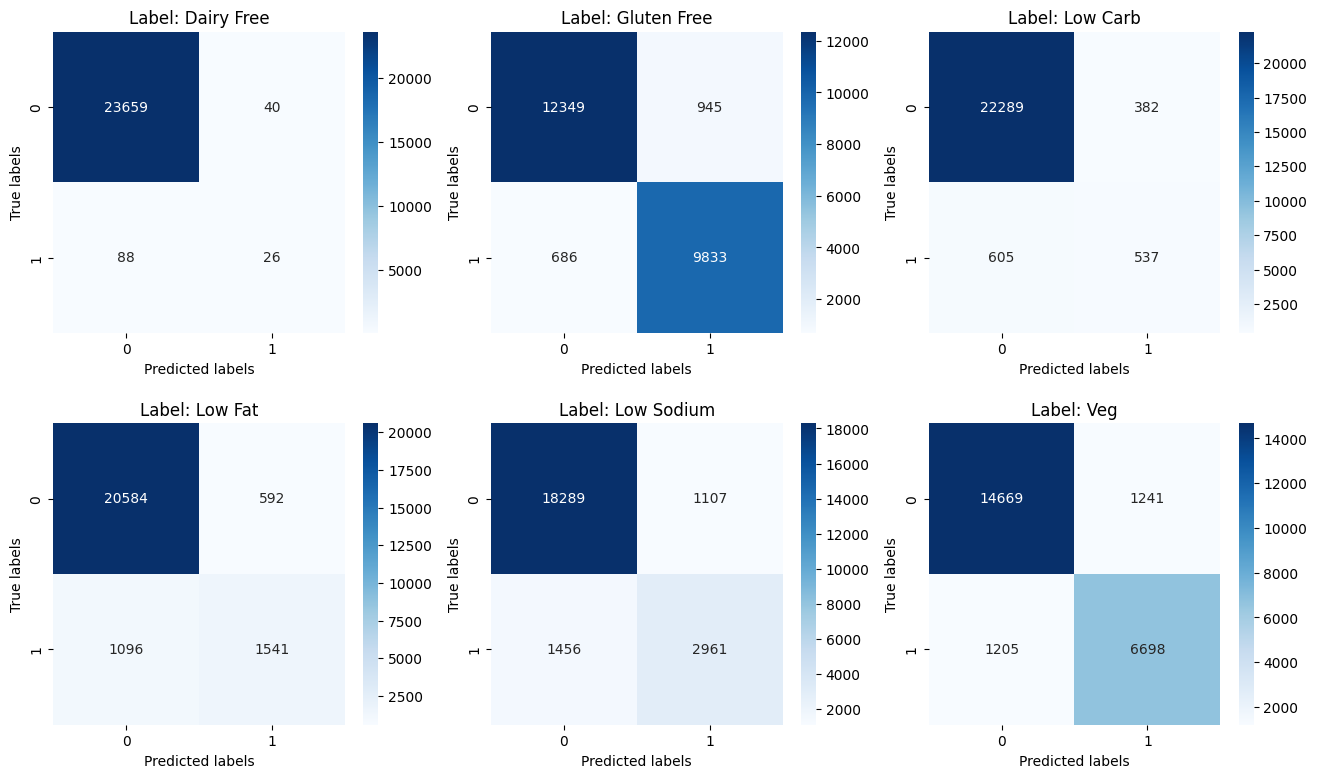

{'eval_loss': 0.19610799849033356, 'eval_f1': 0.8205946613470124, 'eval_roc_auc': 0.8853940396868855, 'eval_accuracy': 0.6985260152017806, 'eval_runtime': 1819.6022, 'eval_samples_per_second': 13.087, 'eval_steps_per_second': 1.636}


In [42]:
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics_test
)

# Evaluate on the test set
results = trainer.evaluate(eval_dataset=encoded_dataset['test'])

print(results)

In [43]:
encoded_dataset['test'][:5]

{'input_ids': tensor([[101, 164, 112,  ...,   0,   0,   0],
         [101, 164, 112,  ...,   0,   0,   0],
         [101, 164, 112,  ...,   0,   0,   0],
         [101, 164, 112,  ...,   0,   0,   0],
         [101, 164, 112,  ...,   0,   0,   0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1.],
         [0., 1., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1., 1.],
         [0., 1., 0., 1., 0., 1.]])}